In [1]:
%matplotlib inline 

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,eng_macd,macd_diff_12_26_9,body_pct,macd_line_12_26_9,volume,obv_diff_14,eng_rsi,eng_atr_div,eng_adx,adx_14,hour,body,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,6.967909e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,7.448270e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,7.961747e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,8.510623e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.624765,0.506696,0.499412,0.489532,0.020724,0.488177,1.0,0.353456,0.519392,0.000000,1.002425,0.506538,0.764286,9.097338e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.634772,0.888941,0.624850,0.971125,0.362651,1.000000,0.0,0.664288,0.537709,0.301944,-0.975989,0.854984,196.815000,1.654708e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.633511,0.840741,0.374057,0.981544,0.434283,0.000000,0.0,0.676887,0.541855,0.328685,-0.975989,0.158091,196.675000,1.484384e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.631866,0.777896,0.494766,0.983006,0.496049,0.000000,0.0,0.584662,0.545337,0.353515,-0.975989,0.493632,196.670000,1.477119e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.623450,0.456523,0.090577,0.884486,1.000000,0.000000,0.0,0.645760,0.531521,0.348960,-0.975989,0.000000,196.240000,1.166764e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'eng_macd', 'macd_diff_12_26_9', 'body_pct', 'macd_line_12_26_9', 'volume', 'obv_diff_14', 'eng_rsi', 'eng_atr_div', 'eng_adx', 'adx_14', 'hour', 'body']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3808  (2004-01-02 → 2019-02-19)
 windows       : 1717408  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=20
 dataloader    : batches=119, batch_size=32, workers=8, pin_memory=True

--- VAL ---
 calendar days : 783  (2019-02-20 → 2022-03-28)
 windows       : 353133  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=20
 dataloader    : batches=783, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=20
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# importlib.reload(models_custom) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = models_custom.ModelClass(
    n_feats         = len(params.features_cols_tick),
    short_units     = params.hparams["SHORT_UNITS"],
    long_units      = params.hparams["LONG_UNITS"],
    dropout_short   = params.hparams["DROPOUT_SHORT"],
    dropout_long    = params.hparams["DROPOUT_LONG"],
    pred_hidden     = params.hparams["PRED_HIDDEN"],
    window_len      = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv          = params.hparams["USE_CONV"],
    use_tcn           = params.hparams["USE_TCN"],
    use_short_lstm    = params.hparams["USE_SHORT_LSTM"],
    use_transformer   = params.hparams["USE_TRANSFORMER"],
    use_long_lstm     = params.hparams["USE_LONG_LSTM"],
    use_delta         = params.hparams["USE_DELTA"],
    flatten_mode      = params.hparams["FLATTEN_MODE"]
)

model.to(params.device)  

model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (short_lstm): LSTM(20, 48, batch_first=True, bidirectional=True)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.0, inplace=False)
  (feature_proj): Linear(in_features=96, out_features=96, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=384, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=384, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
   

In [6]:
# # model check: overfit one batch: force your model to train on the exact same small set of examples over and over.
# # You should see loss → 0 in a few dozen steps on a single batch.

# # 1) Grab a single batch (no shuffle issues)
# batch = next(iter(train_loader))
# x_pad, y_sig, *_, lengths = batch

# # 2) Move to device
# device = next(model.parameters()).device
# x_pad = x_pad.to(device)
# y_sig = y_sig.to(device)

# # 3) Extract just the first day’s valid windows
# #    lengths[0] might be a tensor or int
# W = lengths[0].item() if isinstance(lengths[0], torch.Tensor) else lengths[0]
# x_day = x_pad[0, :W]       # shape (W, features…)
# y_day = y_sig[0, :W]       # shape (W,)

# # 4) Our single target is the last tick of that day
# target_val = y_day[-1].unsqueeze(0)   # shape (1,)

# # 5) Turn off dropout so we can memorize perfectly
# for m in model.modules():
#     if isinstance(m, Dropout):
#         m.p = 0.0

# # 6) Clear any saved LSTM state (if your model uses h_short/h_long)
# if hasattr(model, "h_short"): model.h_short = None
# if hasattr(model, "h_long"):  model.h_long  = None

# # 7) Set up optimizer & loss
# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
# criterion = MSELoss()

# # 8) Overfit loop: reset state every pass, predict last‐tick, compare scalar→scalar
# model.train()
# for step in range(100):
#     optimizer.zero_grad()

#     # reset hidden state each iteration
#     if hasattr(model, "h_short"): model.h_short = None
#     if hasattr(model, "h_long"):  model.h_long  = None

#     # forward on the full day sequence
#     raw_out = model(x_day)  
#     raw_reg = raw_out[0] if isinstance(raw_out, (tuple, list)) else raw_out

#     # collapse to shape (W,)
#     if raw_reg.dim() == 3:
#         raw_reg = raw_reg[0].squeeze(-1)
#     elif raw_reg.dim() == 2:
#         raw_reg = raw_reg.squeeze(-1)

#     # take *only* the final-tick prediction → scalar
#     pred_val = raw_reg[-1].unsqueeze(0)   # shape (1,)

#     # compute scalar loss
#     loss = criterion(pred_val, target_val)
#     loss.backward()
#     optimizer.step()

#     if (step + 1) % 10 == 0 or step == 0:
#         print(f"Step {step+1:02d}  loss={loss.item():.6f}")


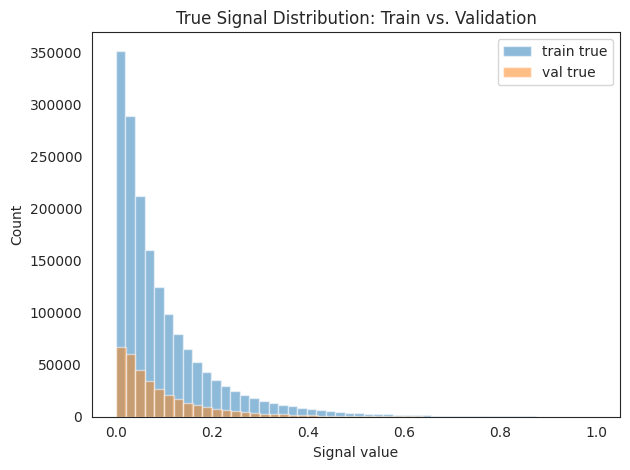

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# if getattr(model, "delta_head", None) is not None:
#     if hasattr(model.delta_head, "weight"):
#         torch.nn.init.zeros_(model.delta_head.weight)
#     if hasattr(model.delta_head, "bias"):
#         torch.nn.init.zeros_(model.delta_head.bias)

# base_lr = params.hparams["ONECYCLE_MAX_LR"]
# wd = params.hparams["WEIGHT_DECAY"]
# base_params = [p for n,p in model.named_parameters() if "delta_head" not in n and p.requires_grad]
# delta_params = [p for n,p in model.named_parameters() if "delta_head" in n and p.requires_grad]

# optimizer = torch.optim.AdamW([
#     {"params": base_params, "lr": base_lr, "weight_decay": wd},
#     {"params": delta_params, "lr": base_lr * 2, "weight_decay": 0.0},
# ])


Training sees 3808 unique trading days per epoch.

Using HyperParameters:
 {'LOOK_BACK': 60, 'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'USE_TCN': False, 'TCN_LAYERS': 2, 'TCN_KERNEL': 3, 'USE_SHORT_LSTM': True, 'SHORT_UNITS': 96, 'DROPOUT_SHORT': 0.0, 'USE_TRANSFORMER': True, 'TRANSFORMER_LAYERS': 1, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.0, 'LONG_UNITS': 64, 'FLATTEN_MODE': 'last', 'PRED_HIDDEN': 96, 'ALPHA_SMOOTH': 0.0, 'USE_DELTA': True, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 1e-05, 'CLIPNORM': 3, 'ONECYCLE_MAX_LR': 0.001, 'ONECYCLE_DIV_FACTOR': 5, 'ONECYCLE_FINAL_DIV': 50, 'ONECYCLE_PCT_START': 0.2, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 32, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN_PREFETCH_FACTOR': 4, 'TOP_K': 99, 'MICRO_SAMPLE_K': 16}


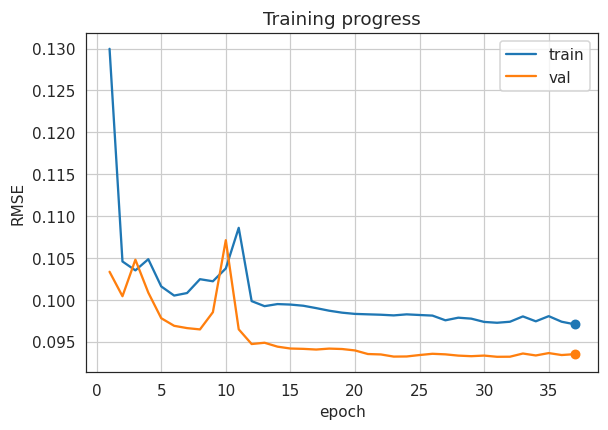

Epoch 1 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 01  TRAIN→ RMSE=0.12997, R²=-0.307 |  VALID→ RMSE=0.10335, R²=0.101 |  lr=2.06e-04 |  loss=1.30408e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.10458, R²=0.154 |  VALID→ RMSE=0.10043, R²=0.151 |  lr=2.24e-04 |  loss=1.15010e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.10352, R²=0.171 |  VALID→ RMSE=0.10479, R²=0.076 |  lr=2.54e-04 |  loss=1.13454e-02 |  improved=False


Epoch 4 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.10485, R²=0.149 |  VALID→ RMSE=0.10086, R²=0.144 |  lr=2.94e-04 |  loss=1.13948e-02 |  improved=False


Epoch 5 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.10160, R²=0.201 |  VALID→ RMSE=0.09781, R²=0.195 |  lr=3.43e-04 |  loss=1.10810e-02 |  improved=True


Epoch 6 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.10051, R²=0.218 |  VALID→ RMSE=0.09690, R²=0.210 |  lr=4.00e-04 |  loss=1.09577e-02 |  improved=True


Epoch 7 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.10081, R²=0.214 |  VALID→ RMSE=0.09662, R²=0.214 |  lr=4.63e-04 |  loss=1.09885e-02 |  improved=True


Epoch 8 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.10246, R²=0.188 |  VALID→ RMSE=0.09647, R²=0.217 |  lr=5.31e-04 |  loss=1.10921e-02 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.10222, R²=0.192 |  VALID→ RMSE=0.09852, R²=0.183 |  lr=6.00e-04 |  loss=1.10517e-02 |  improved=False


Epoch 10 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.10375, R²=0.167 |  VALID→ RMSE=0.10712, R²=0.035 |  lr=6.70e-04 |  loss=1.11964e-02 |  improved=False


Epoch 11 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.10860, R²=0.088 |  VALID→ RMSE=0.09648, R²=0.217 |  lr=7.37e-04 |  loss=1.10979e-02 |  improved=False


Epoch 12 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.09985, R²=0.229 |  VALID→ RMSE=0.09472, R²=0.245 |  lr=8.00e-04 |  loss=1.07376e-02 |  improved=True


Epoch 13 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.09924, R²=0.238 |  VALID→ RMSE=0.09488, R²=0.243 |  lr=8.57e-04 |  loss=1.06873e-02 |  improved=False


Epoch 14 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.09949, R²=0.234 |  VALID→ RMSE=0.09441, R²=0.250 |  lr=9.07e-04 |  loss=1.06958e-02 |  improved=True


Epoch 15 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.09943, R²=0.235 |  VALID→ RMSE=0.09419, R²=0.254 |  lr=9.47e-04 |  loss=1.06721e-02 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.09929, R²=0.237 |  VALID→ RMSE=0.09415, R²=0.254 |  lr=9.76e-04 |  loss=1.06447e-02 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.09901, R²=0.242 |  VALID→ RMSE=0.09407, R²=0.256 |  lr=9.94e-04 |  loss=1.06082e-02 |  improved=True


Epoch 18 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.09870, R²=0.246 |  VALID→ RMSE=0.09418, R²=0.254 |  lr=1.00e-03 |  loss=1.05709e-02 |  improved=False


Epoch 19 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.09847, R²=0.250 |  VALID→ RMSE=0.09413, R²=0.255 |  lr=1.00e-03 |  loss=1.05383e-02 |  improved=False


Epoch 20 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 20  TRAIN→ RMSE=0.09832, R²=0.252 |  VALID→ RMSE=0.09396, R²=0.257 |  lr=9.98e-04 |  loss=1.05130e-02 |  improved=True


Epoch 21 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 21  TRAIN→ RMSE=0.09827, R²=0.253 |  VALID→ RMSE=0.09353, R²=0.264 |  lr=9.96e-04 |  loss=1.04928e-02 |  improved=True


Epoch 22 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 22  TRAIN→ RMSE=0.09822, R²=0.254 |  VALID→ RMSE=0.09348, R²=0.265 |  lr=9.92e-04 |  loss=1.04763e-02 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 23  TRAIN→ RMSE=0.09814, R²=0.255 |  VALID→ RMSE=0.09322, R²=0.269 |  lr=9.88e-04 |  loss=1.04605e-02 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 24  TRAIN→ RMSE=0.09827, R²=0.253 |  VALID→ RMSE=0.09324, R²=0.269 |  lr=9.83e-04 |  loss=1.04593e-02 |  improved=False


Epoch 25 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 25  TRAIN→ RMSE=0.09819, R²=0.254 |  VALID→ RMSE=0.09341, R²=0.266 |  lr=9.77e-04 |  loss=1.04430e-02 |  improved=False


Epoch 26 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 26  TRAIN→ RMSE=0.09812, R²=0.255 |  VALID→ RMSE=0.09356, R²=0.264 |  lr=9.70e-04 |  loss=1.04602e-02 |  improved=False


Epoch 27 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 27  TRAIN→ RMSE=0.09756, R²=0.264 |  VALID→ RMSE=0.09349, R²=0.265 |  lr=9.62e-04 |  loss=1.04005e-02 |  improved=False


Epoch 28 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 28  TRAIN→ RMSE=0.09787, R²=0.259 |  VALID→ RMSE=0.09334, R²=0.267 |  lr=9.53e-04 |  loss=1.04414e-02 |  improved=False


Epoch 29 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 29  TRAIN→ RMSE=0.09775, R²=0.261 |  VALID→ RMSE=0.09327, R²=0.268 |  lr=9.44e-04 |  loss=1.04219e-02 |  improved=False


Epoch 30 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.09736, R²=0.267 |  VALID→ RMSE=0.09334, R²=0.267 |  lr=9.33e-04 |  loss=1.03595e-02 |  improved=False


Epoch 31 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.09726, R²=0.268 |  VALID→ RMSE=0.09320, R²=0.269 |  lr=9.22e-04 |  loss=1.03427e-02 |  improved=True


Epoch 32 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 32  TRAIN→ RMSE=0.09738, R²=0.266 |  VALID→ RMSE=0.09321, R²=0.269 |  lr=9.10e-04 |  loss=1.03573e-02 |  improved=False


Epoch 33 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 33  TRAIN→ RMSE=0.09802, R²=0.257 |  VALID→ RMSE=0.09359, R²=0.263 |  lr=8.97e-04 |  loss=1.04699e-02 |  improved=False


Epoch 34 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 34  TRAIN→ RMSE=0.09744, R²=0.266 |  VALID→ RMSE=0.09336, R²=0.267 |  lr=8.83e-04 |  loss=1.04019e-02 |  improved=False


Epoch 35 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 35  TRAIN→ RMSE=0.09805, R²=0.256 |  VALID→ RMSE=0.09364, R²=0.262 |  lr=8.69e-04 |  loss=1.05181e-02 |  improved=False


Epoch 36 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 36  TRAIN→ RMSE=0.09739, R²=0.266 |  VALID→ RMSE=0.09341, R²=0.266 |  lr=8.54e-04 |  loss=1.04149e-02 |  improved=False


Epoch 37 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.09708, R²=0.271 |  VALID→ RMSE=0.09351, R²=0.264 |  lr=8.38e-04 |  loss=1.03450e-02 |  improved=False


Epoch 38 ▶ Train:   0%|          | 0/119 [00:00<?, ?it/s]

eval:   0%|          | 0/783 [00:00<?, ?it/s]

In [ ]:
importlib.reload(params) #############
importlib.reload(models_custom) #############
importlib.reload(models_core) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n', params.hparams)

optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = params.hparams['CLIPNORM'],
    alpha_smooth        = params.hparams['ALPHA_SMOOTH'],
    lambda_delta        = params.hparams['LAMBDA_DELTA'],
    top_k               = params.hparams['TOP_K']
)

In [ ]:
print("model device", next(model.parameters()).device)

for n,p in model.named_parameters():
    if p.grad is not None and ("delta_head" in n or "head_flat" in n):
        print("GRAD", n, p.grad.norm().item())

for i,g in enumerate(optimizer.param_groups):
    print("PG", i, "lr", g.get("lr"), "wd", g.get("weight_decay"), "n_params", sum(1 for _ in g["params"]))
print("delta params", [n for n,_ in model.named_parameters() if "delta_head" in n])
